
### This notebook walks through basic code examples for integrating various packages with Neo4j, including py2neo, ipython-cypher, pandas, networkx, igraph, and graph3d.

In [20]:
import sys
sys.path.insert(0,'/Users/Zhen/Desktop/Courses/BigData/stackexchange/graphAnalysis/neo4j-jupyter-master')
from py2neo import Graph
from scripts.vis import draw
from py2neo import authenticate, Graph

# set up authentication parameters
authenticate("localhost:7474", "neo4j", "1")

graph = Graph("http://localhost:7474/db/data/")

In [7]:
# graph.delete_all()

### get the most active user and plot

In [21]:
import numpy as np
import pandas as pd
query="""
MATCH (u:user)-[t:Answer]->(p:answer)
RETURN u.ID as ID, count(*) AS answerCount
ORDER BY answerCount DESC
LIMIT 10
"""
most_answer_person = graph.cypher.execute(query)
most_answer_person

    | ID   | answerCount
----+------+-------------
  1 | 2452 |          84
  2 | 381  |          50
  3 | 609  |          32
  4 | 21   |          32
  5 | 434  |          29
  6 | 108  |          25
  7 | 847  |          24
  8 | 1279 |          24
  9 | 819  |          24
 10 | 8878 |          22

In [16]:
# convert to dataFrame
a=[]
for row in most_answer_person:
    a.append((row[0],row[1]))
most_answer_person_frame=pd.DataFrame(a,columns=['ID','answerCount'])

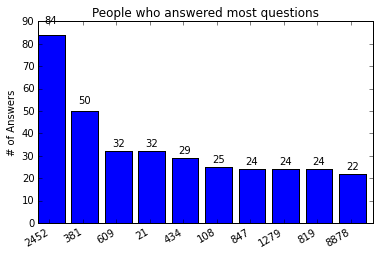

In [13]:
# plot 
%matplotlib inline  
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

fig = plt.figure()
ind = np.arange(10)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1=ax.bar(ind, most_answer_person_frame.iloc[:,1])
fig.autofmt_xdate()

# add some text for labels, title and axes ticks
ax.set_ylabel('# of Answers')
ax.set_title('People who answered most questions')
ax.set_xticks(ind + width)
ax.set_xticklabels(most_answer_person_frame.iloc[:,0])

# ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)

plt.show()

## next we are going to extract data from Neo4j and draw a network graph of tags using Force-Directed Graph

In [25]:
%load_ext cypher
# get all pairs of tags what appear in the same documents
query="""
MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
Where toInt(q.ID)>toInt(u.ID)
RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
ORDER BY tag_cooccurence DESC
"""
tag_cooccurence = graph.cypher.execute(query)
tag_cooccurence

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


      | u.TagName                 | q.TagName                 | tag_cooccurence
------+---------------------------+---------------------------+-----------------
    1 | machine-learning          | classification            |              76
    2 | machine-learning          | data-mining               |              69
    3 | machine-learning          | r                         |              48
    4 | machine-learning          | python                    |              34
    5 | machine-learning          | neuralnetwork             |              34
    6 | machine-learning          | statistics                |              30
    7 | machine-learning          | algorithms                |              27
    8 | bigdata                   | data-mining               |              26
    9 | machine-learning          | bigdata                   |              26
   10 | machine-learning          | predictive-modeling       |              26
   11 | machine-learning          | dat

In [18]:
# convert the above result to dataFrame format, and then to json format
import json
a=[]
for row in tag_cooccurence:
    a.append((row[0],row[1],row[2]))
tag_cooccurence_frame=pd.DataFrame(a,columns=['source','target','value'])
tag_cooccurence_json=tag_cooccurence_frame.to_json(path_or_buf = None, orient = 'records', date_format = 'epoch', double_precision = 10, force_ascii = True, date_unit = 'ms', default_handler = None)
# write the file
with open("./outputData/tag_graph.json", "w") as f:
    json.dump(json.loads(tag_cooccurence_json),f,ensure_ascii=False,indent=2)
# now the tag_graph.json file can be used as an input of the Force-Directed Graph

## From the force-directed graph, we can observe some tages have strong connection with other tags, while others do not. Also, there is hard to observe the pattern near the center of the graph because so many links intersect in the center.
## So we use a edge bunding graph to help us better visualize it.

In [18]:
query="""
MATCH (u:tag)
RETURN u.ID,u.TagName,u.TagCount
"""
tag_node = graph.cypher.execute(query)
a=[]
for row in tag_node:
    a.append((row[0],row[1],row[2]))
tag_frame=pd.DataFrame(a,columns=['ID','Name','Count'])
tag_frame

,ID,Name,Count
0,1,definitions,12
1,2,machine-learning,420
2,3,bigdata,115
3,5,data-mining,171
4,6,databases,19
5,8,libsvm,4
6,10,scalability,16
7,11,efficiency,19
8,12,performance,19
9,13,nosql,12


In [20]:
# for each tag, find all the tags that occure in the same document
df=[];
for i in range(tag_frame.shape[0]):
    query="""
            MATCH (u:tag)<-[:hasTag]-(p:ask)-[:hasTag]->(q:tag)
            WHERE u.TagName="%%"
            RETURN u.TagName, q.TagName, count(*) AS tag_cooccurence
            ORDER BY tag_cooccurence DESC
          """.replace("%%",tag_frame.iloc[i,1])
    tag_relate = graph.cypher.execute(query)
    a=(tag_frame.iloc[i,1],tag_frame.iloc[i,2],[row[1] for row in tag_relate])
    df.append(a)
tag_relation_frame=pd.DataFrame(df,columns=['name','size','imports'])
tag_relation_frame

,name,size,imports
0,definitions,12,"[knowledge-base, education, tools, text-mining..."
1,machine-learning,420,"[classification, data-mining, r, python, neura..."
2,bigdata,115,"[data-mining, machine-learning, hadoop, effici..."
3,data-mining,171,"[machine-learning, bigdata, classification, cl..."
4,databases,19,"[bigdata, nosql, data-mining, sql, machine-lea..."
5,libsvm,4,"[machine-learning, svm, nlp, bigdata, dimensio..."
6,scalability,16,"[bigdata, efficiency, distributed, performance..."
7,efficiency,19,"[bigdata, performance, scalability, distribute..."
8,performance,19,"[efficiency, bigdata, scalability, machine-lea..."
9,nosql,12,"[databases, bigdata, hadoop, data-indexing-tec..."


In [21]:
tag_relation_json=tag_relation_frame.to_json(path_or_buf = None, orient = 'records', date_format = 'epoch', double_precision = 10, force_ascii = True, date_unit = 'ms', default_handler = None)
with open("./outputData/tag_relation.json", "w") as f:
    json.dump(json.loads(tag_relation_json),f,ensure_ascii=False,indent=2)